In [1]:
import os
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pyvista as pv
from skimage.filters import gaussian
from scipy.ndimage import zoom
import ipywidgets
from pathlib import Path
from tqdm import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
PIPELINE_ROOT = Path('./').absolute().parents[1]
PIPELINE_ROOT = PIPELINE_ROOT.as_posix()
sys.path.append(PIPELINE_ROOT)
print(PIPELINE_ROOT)

data_path = '/net/birdstore/Active_Atlas_Data/data_root/atlas_data'

/home/eddyod/programming/pipeline/src


In [22]:
structure = 'VCA_L'
structure = 'SC'
allen_color = 851
threshold = 0.50
atlas = 'AtlasV8'

In [5]:
arrpath = f'/net/birdstore/Active_Atlas_Data/data_root/atlas_data/{atlas}/structure/{structure}.npy'
arr7 = np.load(arrpath)
arr7 = np.rot90(arr7, axes=(0, 1)) 
arr7 = np.flip(arr7, axis=0)
arr7[arr7 > threshold] = allen_color
arr7[arr7 != allen_color] = 0
print(arr7.shape, arr7.dtype)

(116, 123, 62) float64


In [23]:
arrpath = os.path.join(data_path, f'{atlas}/structure/{structure}.npy')
arr = np.load(arrpath)
#volume = gaussian(volume, 1)
#arr8[arr8 > threshold] = allen_color
#arr8[arr8 != allen_color] = 0
ids, counts = np.unique(arr, return_counts=True)
print(ids)
print(counts)
print(arr.shape, arr.dtype)
#(131, 160, 186) float64

[0.00000000e+00 7.98997205e-13 1.59799441e-12 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
[7134335   26267     248 ...     272   14783 1825067]
(214, 179, 362) float64


In [7]:
animal = 'MD589'
path = f'/net/birdstore/Active_Atlas_Data/data_root/atlas_data/{animal}/structure/{structure}.npy'
animal_volume = np.load(path)
#animal_volume[animal_volume > threshold] = allen_color
#animal_volume[animal_volume != allen_color] = 0
ids, counts = np.unique(animal_volume, return_counts=True)
print(ids)
print(counts)
print(animal_volume.shape, animal_volume.dtype)

[0 1]
[541906 166718]
(114, 111, 56) uint8


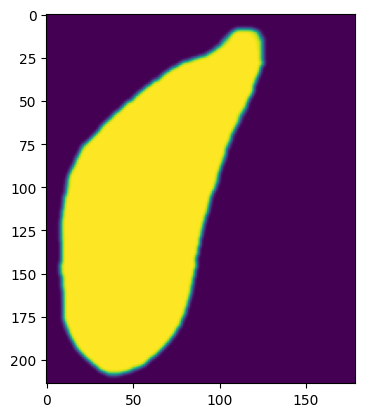

In [26]:
volume = arr.copy()
volume[volume > 0.5] = allen_color
volume[volume != allen_color] = 0
volume = gaussian(volume, 1.0)
volume = volume.astype(np.uint32)

x,y,z = np.array(volume.shape) // 2
plt.imshow(volume[:, :, z])

/usr/local/share/pipeline/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


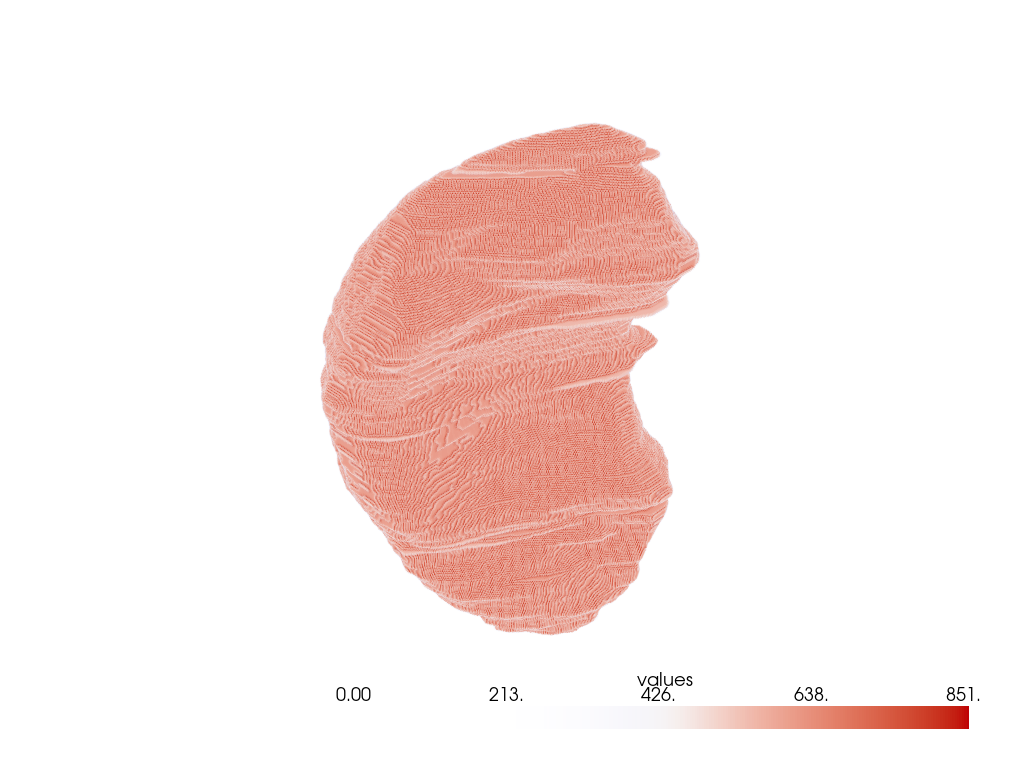

In [27]:
#pv.set_jupyter_backend("trame")
#data = pv.wrap(volume)
#data.plot(volume=True) # Volume render
# Plot the volume with a transfer function
plotter = pv.Plotter()
plotter.add_volume(volume, cmap="coolwarm", opacity="sigmoid", show_scalar_bar=True)
plotter.show()